# Abstracting Inputs

## Imports

In [1]:
import src.utils as utils

In [2]:
import ipynb.fs.full.x0_3_HDD as hdd

In [3]:
import ipynb.fs.full.x0_1_GrammarFuzzer as fuzzer

In [4]:
import ipynb.fs.full.x0_2_Parser as parser

In [5]:
from ipynb.fs.full.x0_3_HDD import PRes

In [6]:
import ast
import json

In [7]:
import random

In [8]:
random.seed(0)

## Expression Grammar

In [9]:
EXPR_GRAMMAR = {
 '<start>': [['<expr>']],
 '<expr>': [['<term>', '+', '<expr>'],
            ['<term>', '-', '<expr>'],
            ['<term>']],
 '<term>': [['<factor>', '*', '<term>'],
            ['<factor>', '/', '<term>'],
            ['<factor>']],
 '<factor>': [['+', '<factor>'],
              ['-', '<factor>'],
              ['(', '<expr>', ')'],
              ['<integer>', '.', '<integer>'],
              ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

EXPR_START = '<start>'

## Predicate

In [10]:
import re
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    return PRes.failed

In [11]:
expr_parser = parser.EarleyParser(EXPR_GRAMMAR)

In [12]:
my_input = '1+((2*3/4))'
assert expr_double_paren(my_input) == PRes.success

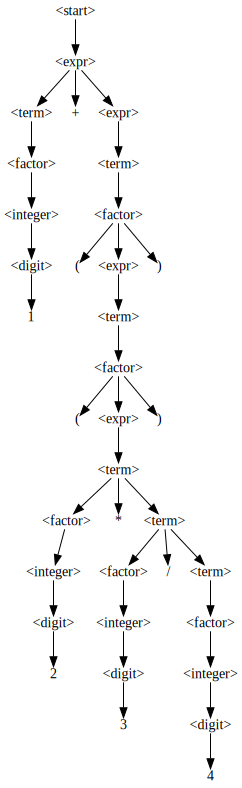

In [13]:
parsed_expr = list(expr_parser.parse_on(my_input, '<start>'))[0]
utils.display_tree(parsed_expr)

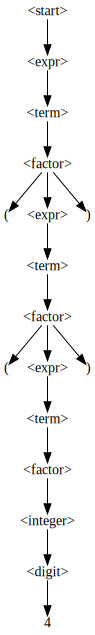

In [14]:
reduced_expr_tree = hdd.hierarchical_reduction(parsed_expr, EXPR_GRAMMAR, expr_double_paren)
utils.display_tree(reduced_expr_tree)

## DDSet Simple

In [15]:
def ddset(reduced_tree, grammar, predicate):
    vals = generalize(reduced_tree, [], [], grammar, predicate)
    ta = get_abstract_tree(reduced_tree, vals)
    return ta

The `generalize()` procedure tries to generalize a given tree recursively. For that, it starts at the root node, and replaces the node with
a randomly generated tree rooted at the same node. It tries that a configurable number of times, and if the tree can be replaced each time
without failure, then we mark the path as abstract. If not, we descent into its children and try the same. While generating a new tree, any
previous nodes marked as abstract is also replaced by randomly generated values.

In [16]:
def generalize_topdown(tree, path, known_paths, grammar, predicate):
    node = hdd.get_child(tree, path)
    if not utils.is_nt(node[0]): return known_paths
    if can_abstract(tree, path, known_paths, grammar, predicate):
        known_paths.append(path)
        return known_paths
    for i,child in enumerate(node[1]):
        ps = generalize(tree, path + [i], known_paths, grammar, predicate)
    return known_paths

In [17]:
def generalize_bottomup(tree, path, known_paths, grammar, predicate):
    node = hdd.get_child(tree, path)
    if not utils.is_nt(node[0]): return []
    kpaths = []
    for i,child in enumerate(node[1]):
        ps = generalize(tree, path + [i], kpaths + known_paths, grammar, predicate)
        if ps:
            kpaths.extend(ps)
        
    if can_abstract(tree, path, known_paths, grammar, predicate):
        return [path]
    return kpaths + known_paths

In [18]:
def generalize(tree, path, known_paths, grammar, predicate):
    return generalize_bottomup(tree, path, known_paths, grammar, predicate)

The `can_abstract()` procedure above does the checking to see if the tree can be abstracted. It is implemented as follows.

In [19]:
MAX_TRIES_FOR_ABSTRACTION = 100

def can_abstract(tree, path, known_paths, grammar, predicate):
    i = 0
    while (i < MAX_TRIES_FOR_ABSTRACTION):
        t = replace_all_paths_with_generated_values(tree, known_paths + [path], grammar)
        s = utils.tree_to_str(t)
        if predicate(s) == hdd.PRes.failed:
            return False
        elif predicate(s) == hdd.PRes.invalid:
            continue
        i += 1
    return True

The `can_abstract()` procedure tries to generate a valid value `MAX_TRIES_FOR_ABSTRACTION` times. For this, it relies on
`replace_all_paths_with_generated_values()` which is implemented as follows.

In [20]:
def replace_all_paths_with_generated_values(tree, paths, grammar):
    my_tree = tree
    for p in paths:
        my_tree = replace_path_with_generated_value(my_tree, p, grammar)
    return my_tree

Here, the major work is done by `replace_path_with_generated_value()` which replaces a single given path with a generated node
of the same kind.

In [21]:
def replace_path(tree, path, new_node=None):
    if new_node is None: new_node = []
    if not path: return utils.deep_copy(new_node)
    cur, *path = path
    name, children, *rest = tree
    new_children = []
    for i,c in enumerate(children):
        if i == cur:
            nc = replace_path(c, path, new_node)
        else:
            nc = c
        if nc:
            new_children.append(nc)
    return (name, new_children, *rest)

def replace_path_with_generated_value(tree, path, grammar):
    node = hdd.get_child(tree, path)
    s, gnode = generate_random_value(grammar, node[0])
    t = replace_path(tree, path, gnode)
    return t

Given a key, generate a random value for that key using the grammar. 

In [22]:
def generate_random_value(grammar, key):
    my_fuzzer = fuzzer.LimitFuzzer(grammar)
    node = my_fuzzer.iter_gen_key(key, max_depth=10)
    return (utils.tree_to_str(node), node)

Finally, the converter from an abstract tree to a string expression

In [23]:
def abstract_tree_to_str(tree):
    name, children, *general_ = tree
    if not utils.is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([abstract_tree_to_str(c) for c in children])

We also need a few library functions for marking some nodes concrete and some abstract.

In [24]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

def mark_path_abstract(tree, path):
    name, children = hdd.get_child(tree, path)
    new_tree = replace_path(tree, path, (name, children, {'abstract': True}))
    return new_tree

def get_abstract_tree(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, path)
    return mark_concrete_r(tree)

def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

With this, we are ready to extract our pattern.

In [25]:
class DisplayAbstractTree(utils.DisplayTree):
    def extract_node(self, node, id):                                                      
        symbol, children, *annotation = node 
        if is_node_abstract(node): return symbol, [], ''
        return symbol, children, ''.join(str(a) for a in annotation)

In [26]:
def display_abstract_tree(node):
    return DisplayAbstractTree(node).display()

### Example

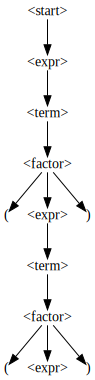

In [27]:
pattern = ddset(reduced_expr_tree, EXPR_GRAMMAR, expr_double_paren)
display_abstract_tree(pattern)

In [28]:
def tree_to_str_abs(node):
    symbol, children, *rest = node
    if is_node_abstract(node): return symbol
    if utils.is_nt(symbol):
        return ''.join([tree_to_str_abs(c) for c in children])
    else:
        return symbol

In [29]:
tree_to_str_abs(pattern)

'((<expr>))'

# Single Fault Grammar

The basic idea is that if we can find an abstract subtree of the evocative pattern derivation tree, such that the presence of this abstract subtree in the input guarantees the failure, then we can modify the grammar such that this abstract subtree is always present (we call the abstract subtree an evocative subtree). That is, for any input from such a grammar, at least one instance of the evocative subtree will be present. This is fairly easy to do if the generated tree contains a nonterminal of the same kind as that of the top node of the evocative subtree. Simply replace that node with the evocative subtree, and fill in the abstract nonterminals in the evocative subtree with concrete expansions.

## Reachable Grammar

On the other hand, this gives us an idea. What if we modify the grammar such that at least one instance of such a nonterminal is present? Such a grammar is called the `reachable_grammar`. To produce a reaching grammar, first we need to find what nonterminals are reachable from the expansion of a given nonterminal. A nonterminal `<A>` is reachable from another nonterminal `<B>` if and only if one of the expansion rules for `<B>` contains the nonterminal `<A>` or it is reachable from one of the nonterminals in the expansion rules of `<B>`. Note that it is not enough to be the same nonterminal. That is, (for e.g.) `<A>` is not # reachable from `<A>` if expansion rules of `<A>` contain only terminal symbols.

In [30]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not utils.is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar,
                        token, reachable_keys, found_so_far)
    return found_so_far

In [31]:
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, {})
    print(key, keys)


<start> {'<expr>', '<integer>', '<digit>', '<term>', '<factor>'}
<expr> {'<expr>', '<integer>', '<digit>', '<term>', '<factor>'}
<term> {'<expr>', '<integer>', '<digit>', '<term>', '<factor>'}
<factor> {'<expr>', '<integer>', '<digit>', '<term>', '<factor>'}
<integer> {'<digit>', '<integer>'}
<digit> set()


We can now collect it in a data structure for easier access

In [32]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

That is, if we want to know the nonterminals that are reachable from `<integer>`, we can simply do

In [33]:
reaching = reachable_dict(EXPR_GRAMMAR)
print(reaching['<integer>'])

{'<digit>', '<integer>'}


That is, only `<digit>` and `<integer>` are reachable from the expansion of nonterminal `<integer>`
    

## Reachable positions.

Next, given an evocative subtree, we want to find what tokens of the grammar can actually embed such a subtree. We call the top node of an evocative subtree its characterizing node, and the nonterminal the characterizing nonterminal of the evocative subtree.

In [34]:
def get_reachable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not utils.is_nt(token): continue
        if fkey == token or fkey in reachable[token]:
            positions.append(i)
    return positions

Say we assume that `<factor>` is the characterizing nonterminal. Here are the locations in grammar where one can embed the evocative subtree.

In [35]:
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_reachable_positions(rule, '<factor>', reaching)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', '+', '<expr>'] [0, 2]
	 ['<term>', '-', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', '*', '<term>'] [0, 2]
	 ['<factor>', '/', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


## Insertion Grammar

Given the insertion locations, can we produce a grammar such that we can guarantee that at least one instance of evocative subtree can be inserted? To do that, all we need to guarantee is that the start node in any derivation tree can reach the characterizing nonterminal. For now, let us call our fault `F1`. Let us indicate that our start symbol guarantees reachability of characterizing nonterminal by specializing it. So, our new start symbol is `<start F1>`

Next, for the start symbol to guarantee reachability to characterizing nonterminal, all that we need to ensure is that all the expansion rules of start can reach the characterizing nonterminal. On the other hand, for a guarantee that an expansion rule can reach the characterizing nonterminal, all that is required is that one of the nonterminals in that rule guarantees reachability. We start with a few helper functions

In [36]:
def tsplit(token):
    assert token[0], token[-1] == ('<', '>')
    front, *back = token[1:-1].split(None, 1)
    return front, ' '.join(back)

def refinement(token):
    return tsplit(token)[1].strip()

def is_refined_key(key):
    assert utils.is_nt(key)
    return (' ' in key)

def is_base_key(key):
    return not is_refined_key(key)

def stem(token):
    return tsplit(token)[0].strip()

def normalize(token):
    assert utils.is_nt(token), token
    if is_base_key(token): return token
    return '<%s>' % stem(token)

def refine_base_key(k, prefix):
    assert utils.is_nt(k), k
    assert is_base_key(k), k
    return '<%s %s>' % (stem(k), prefix)

Defining the `reachable_key()`

In [37]:
def reachable_key(grammar, key, cnodesym, suffix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_reachable_positions(rule, cnodesym, reachable)
        if not positions:
            # skip this rule because we can not embed the fault here.
            continue
        else:
            # at each position, insert the cnodesym
            for pos in positions:
                new_rule = [refine_base_key(t, suffix)
                            if pos == p else t for p,t in enumerate(rule)]
                my_rules.append(new_rule)
    return (refine_base_key(key, suffix), my_rules)


Used as follows

In [38]:
for key in EXPR_GRAMMAR:
    fk, rules = reachable_key(EXPR_GRAMMAR, key, '<factor>', 'F1', reaching)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start F1>
     ['<expr F1>']

<expr F1>
     ['<term F1>', '+', '<expr>']
     ['<term>', '+', '<expr F1>']
     ['<term F1>', '-', '<expr>']
     ['<term>', '-', '<expr F1>']
     ['<term F1>']

<term F1>
     ['<factor F1>', '*', '<term>']
     ['<factor>', '*', '<term F1>']
     ['<factor F1>', '/', '<term>']
     ['<factor>', '/', '<term F1>']
     ['<factor F1>']

<factor F1>
     ['+', '<factor F1>']
     ['-', '<factor F1>']
     ['(', '<expr F1>', ')']

<integer F1>

<digit F1>



## Pattern Grammar

Next, we need to ensure that our evocative subtree can form a unique subtree. For that, all we need to do is that all nodes in the subtree are named uniquely. Not all nodes in the evocative subtree needs unique names however. DDSet produces trees such that some nodes in the tree are left abstract. We leave these with the original node names.


In [39]:
def mark_unique_name(symbol, suffix, i):
    return '<%s %s_%s>' % (symbol[1:-1], suffix, str(i))

def mark_unique_nodes(node, suffix, counter=None):
    if counter is None: counter = [0]
    symbol, children, *abstract = node
    if is_node_abstract(node): # we don't markup further
        return node
    if utils.is_nt(symbol):
        i = counter[0]
        counter[0] += 1
        cs = [mark_unique_nodes(c, suffix, counter) for c in children]
        return (mark_unique_name(symbol, suffix, i), cs, *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

In [40]:
evocative_pattern = pattern

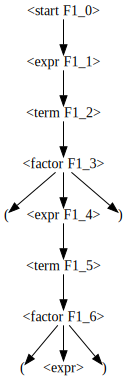

In [41]:
unique_pattern_tree = mark_unique_nodes(evocative_pattern, 'F1')
display_abstract_tree(unique_pattern_tree)

In [42]:
def unique_cnode_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar, normalize(tree[0])
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if utils.is_nt(n):
            unique_cnode_to_grammar(c, grammar)
    grammar[name].append(tokens)
    return grammar, tree[0]

In [43]:
g,s = unique_cnode_to_grammar(unique_pattern_tree)
utils.display_grammar(g,s)

[start]: <start F1_0>
<start F1_0> ::=
|   <expr F1_1>
<expr F1_1> ::=
|   <term F1_2>
<term F1_2> ::=
|   <factor F1_3>
<factor F1_3> ::=
|   '(' <expr F1_4> ')'
<expr F1_4> ::=
|   <term F1_5>
<term F1_5> ::=
|   <factor F1_6>
<factor F1_6> ::=
|   '(' <expr> ')'
keys: 7 rules: 7


We define `pattern_grammar()` that wraps both calls.

In [44]:
def pattern_grammar(cnode, fname):
    unique_pattern_tree = mark_unique_nodes(cnode, fname)
    pattern_g, pattern_s = unique_cnode_to_grammar(unique_pattern_tree)
    return pattern_g, pattern_s, unique_pattern_tree

In [45]:
pattern_g,pattern_s, t = pattern_grammar(evocative_pattern, 'F1')
utils.display_grammar(pattern_g, pattern_s)

[start]: <start F1_0>
<start F1_0> ::=
|   <expr F1_1>
<expr F1_1> ::=
|   <term F1_2>
<term F1_2> ::=
|   <factor F1_3>
<factor F1_3> ::=
|   '(' <expr F1_4> ')'
<expr F1_4> ::=
|   <term F1_5>
<term F1_5> ::=
|   <factor F1_6>
<factor F1_6> ::=
|   '(' <expr> ')'
keys: 7 rules: 7


We define a procedure to reverse our pattern grammar to ensure we can get back our tree.

In [46]:
def pattern_grammar_to_tree(g, s):
    rules = g[s]
    assert len(rules) == 1
    children = [pattern_grammar_to_tree(g,t) if t in g else (t, [])
            for t in rules[0]]
    return (s, children)

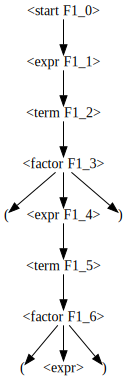

In [47]:
c_tree = pattern_grammar_to_tree(pattern_g,pattern_s)
utils.display_tree(c_tree)

Given the reaching grammar and the pattern grammar, we can combine them to produce the complete grammar

In [48]:
def reachable_grammar(grammar, start, cnodesym, suffix, reachable):
    new_grammar = {}
    s_key = None
    for key in grammar:
        fk, rules = reachable_key(grammar, key, cnodesym, suffix, reachable)
        assert fk not in new_grammar
        if key == start: s_key = fk
        new_grammar[fk] = rules
    return new_grammar, s_key

In [49]:
evocative_subtree = evocative_pattern[1][0][1][0][1][0]
my_key_f = evocative_subtree[0]
reaching = reachable_dict(EXPR_GRAMMAR)
reach_g, reach_s = reachable_grammar(EXPR_GRAMMAR,
        EXPR_START, my_key_f, 'F1', reaching)
utils.display_grammar(reach_g, reach_s)

[start]: <start F1>
<start F1> ::=
|   <expr F1>
<expr F1> ::=
|   <term F1> '+' <expr>
|   <term> '+' <expr F1>
|   <term F1> '-' <expr>
|   <term> '-' <expr F1>
|   <term F1>
<term F1> ::=
|   <factor F1> '*' <term>
|   <factor> '*' <term F1>
|   <factor F1> '/' <term>
|   <factor> '/' <term F1>
|   <factor F1>
<factor F1> ::=
|   '+' <factor F1>
|   '-' <factor F1>
|   '(' <expr F1> ')'
[not_used]
<integer F1> ::=
<digit F1> ::=
keys: 4 rules: 14


## Insert A Fault

In [50]:
def atleast_one_fault_grammar(grammar, start_symbol, cnode, fname):
    key_f = cnode[0]
    pattern_g, pattern_s, t = pattern_grammar(cnode, fname)

    reachable_keys = reachable_dict(grammar)
    reach_g, reach_s = reachable_grammar(grammar,
            start_symbol, key_f, fname, reachable_keys)

    combined_grammar = {**grammar, **pattern_g, **reach_g}
    reaching_sym = refine_base_key(key_f, fname)
    combined_grammar[reaching_sym] = reach_g[reaching_sym] + pattern_g[pattern_s]

    return combined_grammar, reach_s

In [51]:
g, s = utils.grammar_gc(*atleast_one_fault_grammar(EXPR_GRAMMAR,
    EXPR_START, evocative_subtree, 'F1'))
utils.display_grammar(g, s)

[start]: <start F1>
<start F1> ::=
|   <expr F1>
<expr F1> ::=
|   <term F1> '+' <expr>
|   <term> '+' <expr F1>
|   <term F1> '-' <expr>
|   <term> '-' <expr F1>
|   <term F1>
<term F1> ::=
|   <factor F1> '*' <term>
|   <factor> '*' <term F1>
|   <factor F1> '/' <term>
|   <factor> '/' <term F1>
|   <factor F1>
<expr> ::=
|   <term> '+' <expr>
|   <term> '-' <expr>
|   <term>
<term> ::=
|   <factor> '*' <term>
|   <factor> '/' <term>
|   <factor>
<factor F1> ::=
|   '+' <factor F1>
|   '-' <factor F1>
|   '(' <expr F1> ')'
|   '(' <expr F1_1> ')'
<factor> ::=
|   '+' <factor>
|   '-' <factor>
|   '(' <expr> ')'
|   <integer> '.' <integer>
|   <integer>
<expr F1_1> ::=
|   <term F1_2>
<term F1_2> ::=
|   <factor F1_3>
<factor F1_3> ::=
|   '(' <expr> ')'
<integer> ::=
|   <digit> <integer>
|   <digit>
<digit> ::=
|   '0'
|   '1'
|   '2'
|   '3'
|   '4'
|   '5'
|   '6'
|   '7'
|   '8'
|   '9'
[not_used]
<start> ::=
|   <expr>
<factor F1_0> ::=
|   '(' <expr F1_1> ')'
keys: 12 rules: 41

## Number the nodes.

In [52]:
def numbered_nodes(node, count, keys):
    symbol, children, *rest = node
    if is_node_abstract(node):
        return symbol, children, *rest
    if utils.is_nt(symbol):
        key = "<%s %d>" % (symbol[1:-1], count[0])
        keys.append((key, node))
        count[0] += 1
        return key, [numbered_nodes(c, count, keys) for c in children], *rest
    else:
        return symbol, children, *rest

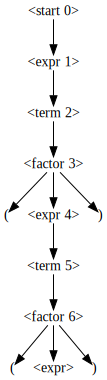

In [53]:
keys = []
nnodes = numbered_nodes(pattern, [0], keys)
display_abstract_tree(nnodes)

In [54]:
keys

[('<start 0>',
  ('<start>',
   [('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('4', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': True}),
                (')', [], {'abstract': False})],
               {'abstract': False})],
             {'abstract': False})],
           {'abstract': False}),
          (')', [], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': False})),
 ('<

In [55]:
def abs_tree_to_grammar(node, grammar = None):
    if grammar is None: grammar = {}
    symbol, children, *rest = node
    grammar[symbol] = [[c[0] for c in children]]
    if is_node_abstract(node):
        return grammar
    if utils.is_nt(symbol):
        [abs_tree_to_grammar(c, grammar) for c in children]
    return grammar

In [56]:
abs_tree_to_grammar(nnodes)

{'<start 0>': [['<expr 1>']],
 '<expr 1>': [['<term 2>']],
 '<term 2>': [['<factor 3>']],
 '<factor 3>': [['(', '<expr 4>', ')']],
 '(': [[]],
 '<expr 4>': [['<term 5>']],
 '<term 5>': [['<factor 6>']],
 '<factor 6>': [['(', '<expr>', ')']],
 '<expr>': [['<term>']],
 ')': [[]]}

In [57]:
def check_context(base_grammar,base_key, tree, predicate):
    keys = []
    nnodes = numbered_nodes(tree, [0], keys)
    for k in reversed(keys):
        abs_key, node = k
        # replace the base_grammar key by abstract grammar and check if it works.
        # if it works, that is our grammar.
        new_g,new_s = atleast_one_fault_grammar(base_grammar, base_key, node, 'f1')
        if is_valid_grammar(new_g, new_s, predicate):
            return new_s, new_g
    return base_grammar

In [58]:
def is_valid_grammar(g, s, predicate):
    for i in range(10):
        v,node = generate_random_value(g, s)
        if predicate(v) == PRes.failed:
            return False
    return True

In [59]:
new_s, new_g = check_context(EXPR_GRAMMAR, EXPR_START, pattern, expr_double_paren)

In [60]:
utils.display_grammar(new_g, new_s)

[start]: <start f1>
<start f1> ::=
|   <expr f1>
<expr f1> ::=
|   <term f1> '+' <expr>
|   <term> '+' <expr f1>
|   <term f1> '-' <expr>
|   <term> '-' <expr f1>
|   <term f1>
<term f1> ::=
|   <factor f1> '*' <term>
|   <factor> '*' <term f1>
|   <factor f1> '/' <term>
|   <factor> '/' <term f1>
|   <factor f1>
<expr> ::=
|   <term> '+' <expr>
|   <term> '-' <expr>
|   <term>
<term> ::=
|   <factor> '*' <term>
|   <factor> '/' <term>
|   <factor>
<factor f1> ::=
|   '+' <factor f1>
|   '-' <factor f1>
|   '(' <expr f1> ')'
|   '(' <expr f1_1> ')'
<factor> ::=
|   '+' <factor>
|   '-' <factor>
|   '(' <expr> ')'
|   <integer> '.' <integer>
|   <integer>
<expr f1_1> ::=
|   <term f1_2>
<term f1_2> ::=
|   <factor f1_3>
<factor f1_3> ::=
|   '(' <expr> ')'
<integer> ::=
|   <digit> <integer>
|   <digit>
<digit> ::=
|   '0'
|   '1'
|   '2'
|   '3'
|   '4'
|   '5'
|   '6'
|   '7'
|   '8'
|   '9'
[not_used]
<start> ::=
|   <expr>
<factor f1_0> ::=
|   '(' <expr f1_1> ')'
<integer f1> ::=
<

In [61]:
new_f = fuzzer.LimitFuzzer(new_g)

In [62]:
for i in range(10):
    v = new_f.iter_gen_key(new_s, 10)
    s = utils.tree_to_str(v)
    print(expr_double_paren(s), s)

PRes.success 2.1685096/50.5++-(9)/++673.15*3*((6))-9.0*2*6.5/8/(0)*0.4/1.0
PRes.success +9838.5++((8.4)*-5-+3*6*((0))/4+2*8.4-5.5)*(10)-1*((6.5)/6)/(4*1+9.2)*-+1.2*-8.1/2/2.1
PRes.success -+00.31867*5.58-((5-1+8.7))/--59+44/--63--((2))/+-7*+(8.3)*3*1.2
PRes.success +3.44*((2*0.4+4+9.5))*-+975.89/++(3.0+7)*-(2+9.2)-+5.7/-((8.4)/5.6)-((9.2-4.6)-5/0/0)/71+-7+0.9
PRes.success (-(3*0+9-4)*76.5*60.42*+5*5.0/9-(((8))*8.1+4)*53)-663
PRes.success +((9.1*7))/3/-0*9.9272/5.55*(7.0)/6/0.4*5
PRes.success 7.5*(+91.46*70.3-41/6.8*9)*--2*(+9)/(0*7.1-0.5)*(9+0)/-4.9+9/-((0))/++(1)/(2-5.6+2.0)*21.1+373.8/6-4.1-06/62++-1.5
PRes.success +((7/0.9-2)*77/-8*1.5*3-48*3*5.7-(7)/9/6-8/6+5-2.1)*((4-2-9.2)++-0*7+-0)*((8+0.3)--8.5/9.3*2.4+8.3/3+2.8-4)/8+((8*6.1))*40.63938--+5.6*--+-3.9*(3.3*1.8)/0.58*9.0*3
PRes.success +++-+--((2))*-(2.9/9)-1
PRes.success ((8.4*2.6/3.0))*+++86*(-2/0-8.5-7-5)*--(3.0+9)*8/7+(+2.7/6-87.09*+7.0/7.8-(9)/6*7-1)-4*++1*+-+8.1
